In [1]:
!pip install pandas
!pip install pytrec_eval trectools
!pip install transformers

In [2]:
import pandas as pd

column_names = ["query_id", "Q0", "doc_id", "rank", "score", "run_name"]

splade_df = pd.read_csv("splade-dev.trec", sep="\t", names=column_names)
bm25_df = pd.read_csv("bm25-t5-dev.trec", sep="\t", names=column_names)

In [3]:
splade_df.head()

query_id  Q0   doc_id  rank   score run_name
0   1048585  Q0  7187155     0  104472       R0
1   1048585  Q0  7187160     1  100811       R0
2   1048585  Q0  7187157     2   99206       R0
3   1048585  Q0  7187158     3   98698       R0
4   1048585  Q0  3100835     4   86255       R0

In [4]:
bm25_df.head()

query_id  Q0   doc_id  rank    score run_name
0   1048585  Q0  7187157     0  46.6189       R0
1   1048585  Q0  7187156     1  45.7317       R0
2   1048585  Q0  7187158     2  44.6009       R0
3   1048585  Q0  7617404     3  44.5052       R0
4   1048585  Q0  7187155     4  43.8783       R0

In [5]:
column_names_qrels = ["query_id", "zero", "doc_id", "relevance_score"]

qrels_df = pd.read_csv("qrels.dev.tsv", sep="\t", header=None, names=column_names_qrels)

qrels_dict = {}
for _, row in qrels_df.iterrows():
    query_id = row["query_id"]
    zero = row["zero"]
    doc_id = row["doc_id"]
    relevance_score = row["relevance_score"]

    if query_id not in qrels_dict:
        qrels_dict[query_id] = {}

    qrels_dict[query_id][doc_id] = relevance_score
    
qrels_df.head()

query_id  zero   doc_id  relevance_score
0   1102432     0  2026790                1
1   1102431     0  7066866                1
2   1102431     0  7066867                1
3   1090282     0  7066900                1
4     39449     0  7066905                1

In [14]:
column_names_queries = ["query_id", "query"]

queries_df = pd.read_csv("queries.dev.tsv", sep="\t", header=None, names=column_names_queries)
queries_df.head()

query_id                           query
0   1048578  cost of endless pools/swim spa
1   1048579                    what is pcnt
2   1048580               what is pcb waste
3   1048581                   what is pbis?
4   1048582                  what is paysky

### Analyzing evaluation metrics

In [21]:
import pytrec_eval

splade_run_dict = {str(query_id): dict(zip(group['doc_id'], group['score'])) for query_id, group in splade_df.groupby('query_id')}

bm25_run_dict = {str(query_id): dict(zip(group['doc_id'], group['score'])) for query_id, group in bm25_df.groupby('query_id')}

evaluator = pytrec_eval.RelevanceEvaluator(qrels_dict, pytrec_eval.supported_measures)

evaluator = pytrec_eval.RelevanceEvaluator(qrels_dict, {'recall', 'map', 'ndcg'})
splade_results = evaluator.evaluate(splade_run_dict)
bm25_results = evaluator.evaluate(bm25_run_dict)

TypeError: Expected string as key.

### Analyzing queries (looking at categorization)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

queries = []

for query in queries_df["query"]:
    queries.append(query)

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(queries)

kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X)

labels = kmeans.labels_
# for query, label in zip(queries, labels):
#     print(f"Query: {query} -> Cluster: {label}")

/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Query: cost of endless pools/swim spa -> Cluster: 6
Query: what is pcnt -> Cluster: 0
Query: what is pcb waste -> Cluster: 0
Query: what is pbis? -> Cluster: 0
Query: what is paysky -> Cluster: 0
Query: what is paydata -> Cluster: 0
Query: what is pay range for warehouse specialist in minneapolis -> Cluster: 0
Query: what is paula deen's brother -> Cluster: 0
Query: what is paul gum disease -> Cluster: 0
Query: what is patron -> Cluster: 0
Query: how long is a college hockey game -> Cluster: 2
Query:  Androgen receptor define -> Cluster: 6
Query: treasuries cost basis -> Cluster: 6
Query: treasury officer hong kong average salary -> Cluster: 6
Query: what is patricia cornwell's latest book -> Cluster: 0
Query: what is pastoral medicine -> Cluster: 0
Query: what is past perfect present tense -> Cluster: 0
Query:  definition of Executive Officer defined by FRB  -> Cluster: 5
Query: treating diabetes -> Cluster: 6
Query: what is president lincoln known for -> Cluster: 0
Query: what is pas

Query: what is a pleth wave -> Cluster: 0
Query: when did lebron go back to cavaliers -> Cluster: 6
Query: does red and purple make brown? -> Cluster: 3
Query: does referred pain occur when you move your neck -> Cluster: 3
Query: what is a plowman's lunch -> Cluster: 0
Query: what is a plumber candle -> Cluster: 0
Query: what is a plumbus used for -> Cluster: 0
Query: jefferson parish salaries -> Cluster: 6
Query: what is the definition of divergent -> Cluster: 5
Query: what is a pluripotent stem cell? -> Cluster: 0
Query: who is padmavati hindi -> Cluster: 0
Query: jemari name meaning -> Cluster: 6
Query: jenner california population -> Cluster: 6
Query: what is a pn -> Cluster: 0
Query: jenny craig costs per week -> Cluster: 6
Query: what is a pneumatic sleeve device -> Cluster: 0
Query: does restasis come in generic -> Cluster: 3
Query: who is on the old twenty dollar bill -> Cluster: 4
Query: when was dia built -> Cluster: 6
Query: when was diagnosed related group established -> Cl

In [16]:
cluster_dict = {}
for query, label in zip(queries, labels):
    cluster_dict.setdefault(label, []).append(query)

for cluster, queries in cluster_dict.items():
    print(f"Cluster {cluster}: {queries[0]}, {queries[1]}, {queries[2]}")

Cluster 6: cost of endless pools/swim spa,  Androgen receptor define, treasuries cost basis
Cluster 0: what is pcnt, what is pcb waste, what is pbis?
Cluster 2: how long is a college hockey game, how long is a cosmic giga second, how long is a creative writing major
Cluster 5:  definition of Executive Officer defined by FRB , 'com multi unit' zoning definition, trey definition
Cluster 4:  the knee is what type of joint , what is parallel structure? why is it so important in the sermon on the mount?, what is the gram molecular weight of maltose
Cluster 3: what voltage does a fluorescent light work at, +micheal moore does he wear a wig, +what does ca cells mean urine test
Cluster 1: what is the maximum amount you can get out of an atm, 15 oz can in ml, true that people can die from a broken heart


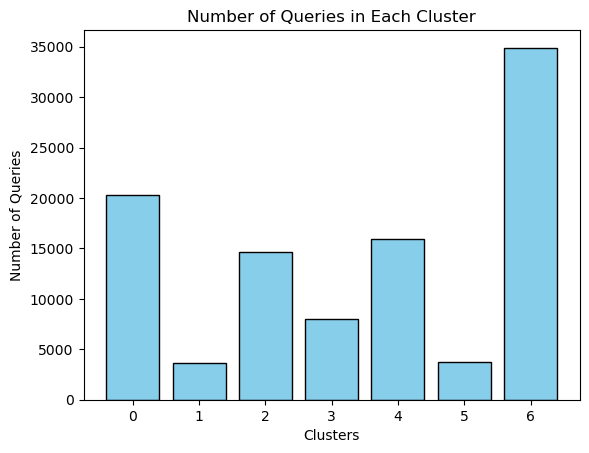

In [17]:
import matplotlib.pyplot as plt

clusters = cluster_dict.keys()
counts = [len(queries) for queries in cluster_dict.values()]

plt.bar(clusters, counts, color='skyblue', edgecolor='black')

plt.xlabel("Clusters")
plt.ylabel("Number of Queries")
plt.title("Number of Queries in Each Cluster")
plt.xticks(ticks=list(clusters))

plt.show()

In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')

def get_main_words(queries, top_n=3):
    combined_text = " ".join(queries)
    vectorizer = CountVectorizer(stop_words=stopwords.words('english'))
    word_counts = vectorizer.fit_transform([combined_text])
    
    word_freq = zip(vectorizer.get_feature_names_out(), word_counts.toarray()[0])
    sorted_words = sorted(word_freq, key=lambda x: x[1], reverse=True)
    
    return [word for word, count in sorted_words[:top_n]]

main_words_by_cluster = {cluster: get_main_words(queries) for cluster, queries in cluster_dict.items()}

for cluster, main_words in main_words_by_cluster.items():
    print(f"Cluster {cluster}: {main_words}")

[nltk_data] Downloading package stopwords to /Users/divya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cluster 6: ['number', 'cost', 'meaning']
Cluster 0: ['county', 'used', 'good']
Cluster 2: ['many', 'long', 'much']
Cluster 5: ['definition', 'legal', 'medical']
Cluster 4: ['name', 'difference', 'meaning']
Cluster 3: ['mean', 'much', 'stand']
Cluster 1: ['cause', 'long', 'get']


### For large dataset (not working)

In [19]:
from transformers import pipeline

classifier = pipeline("text-classification", model="distilbert-base-uncased")

queries = []

for query in queries_df["query"]:
    queries.append(query)
    
predictions = classifier(queries)

for query, pred in zip(queries, predictions):
    print(f"Query: {query} -> Predicted Class: {pred['label']}")

RuntimeError: At least one of TensorFlow 2.0 or PyTorch should be installed. To install TensorFlow 2.0, read the instructions at https://www.tensorflow.org/install/ To install PyTorch, read the instructions at https://pytorch.org/.